# Customer Segmentation using K-Means Clustering
(Unsupervised Learning, RFM, PCA)

## Problem Statement

In [1]:
"""
Objective:
Segment customers based on purchasing behavior to enable targeted marketing
and customer retention strategies.

Approach:
Unsupervised learning using K-Means clustering on customer-level features.
"""

# There are no labels, so the goal is to discover behavioral patterns

'\nObjective:\nSegment customers based on purchasing behavior to enable targeted marketing\nand customer retention strategies.\n\nApproach:\nUnsupervised learning using K-Means clustering on customer-level features.\n'

## Load the Dataset (UCI Online Retail)

In [6]:
import pandas as pd

df = pd.read_excel("Online_Retail.xlsx")
df.to_csv("Online_Retail.csv", index=False)

In [7]:
df = pd.read_csv("Online_Retail.csv")

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Basic Data Understanding

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [11]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
# Missing CustomerID
# Negative Quantity (returns)
# Noise --> must clean before clustering
# Raw transactional data is noisy and must be cleaned before unsupervised learning

## Data Cleaning

In [13]:
# Remove rows with missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Remove cancelled / returned transactions
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

# Convert date column
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create total price
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.head()

# K-Means is sensitive to outliers, so removing noise was essential

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Feature Engineering — RFM

In [14]:
import datetime as dt

snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [15]:
# Recency --> how recently the customer purchased
# Frequency --> how often they purchase
# Monetary --> how much they spend

# RFM captures customer value and engagement in a compact, interpretable way

## EDA on RFM Features

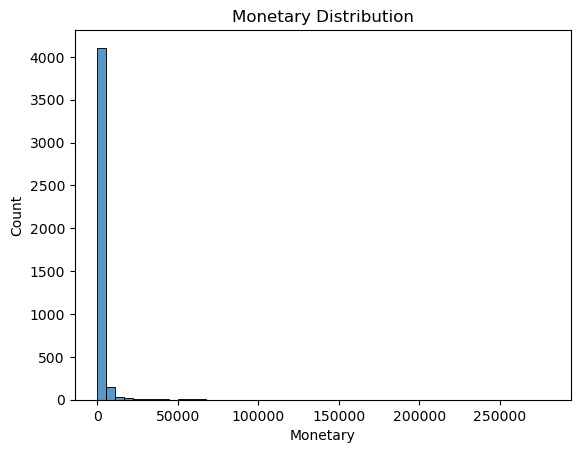

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm["Monetary"], bins=50)
plt.title("Monetary Distribution")
plt.show()

# Strong right skew
# High-value outliers
# Scaling is required

## Feature Scaling

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

## K-Means uses Euclidean distance, so scaling is mandatory

## Choosing Number of Clusters

### Elbow Method

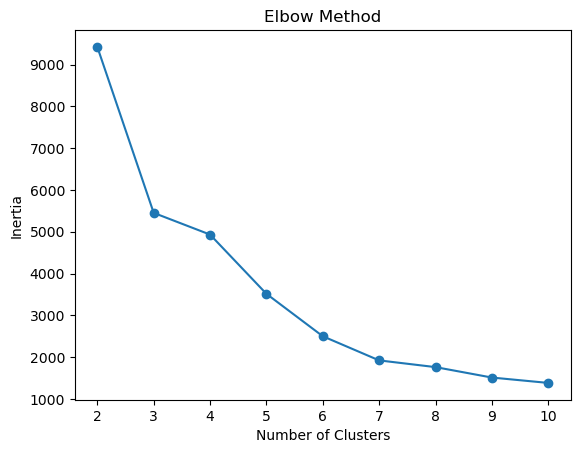

In [18]:
from sklearn.cluster import KMeans

inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


### Silhouette Score

In [20]:
from sklearn.metrics import silhouette_score

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    print(f"k={k}, silhouette={silhouette_score(rfm_scaled, labels):.3f}")

# I used both Elbow and Silhouette to avoid arbitrary cluster selection

k=2, silhouette=0.577
k=3, silhouette=0.602
k=4, silhouette=0.359
k=5, silhouette=0.360


## Final K-Means Model

In [21]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,1
12349.0,19,73,1757.55,0
12350.0,310,17,334.40,3


## PCA for Visualization

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm["PCA1"] = rfm_pca[:, 0]
rfm["PCA2"] = rfm_pca[:, 1]


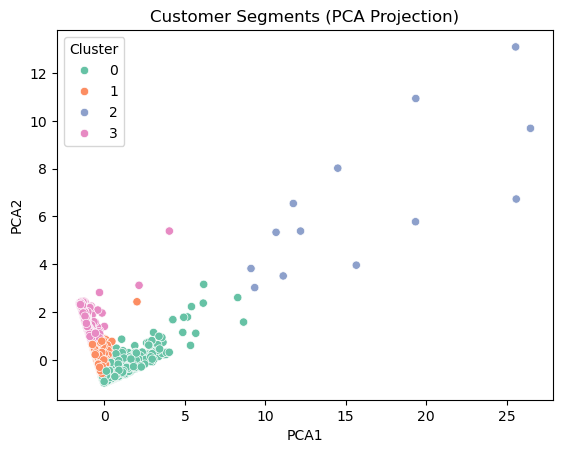

In [23]:
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    data=rfm,
    palette="Set2"
)
plt.title("Customer Segments (PCA Projection)")
plt.show()

# PCA is only for visualization, not for clustering

## Cluster Interpretation

In [25]:
rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,20.990788,135.285122,2645.818172
1,98.218703,37.719457,773.877083
2,4.692308,2565.307692,126118.310000
3,272.407005,25.138889,605.842525


In [ ]:
"""
I labeled clusters like:

High-value loyal customers
Frequent low-spend customers
At-risk / churn-prone customers
Occasional buyers


The goal is actionable segmentation, not just clustering
"""

## Final Conclusion

In [ ]:
"""
Conclusion:
- Segmented customers using K-Means clustering on RFM features
- Applied EDA and scaling to improve cluster quality
- Used Elbow and Silhouette methods for optimal cluster selection
- PCA enabled intuitive visualization of customer segments
- Results can support targeted marketing and retention strategies
"""